<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import numpy as np

In [70]:
dataset, info = tfds.load('cifar10', split=tfds.Split.TRAIN, with_info = True)

dataset_airplanes   = dataset.filter(lambda x: x['label'] == 0)
dataset_automobile  = dataset.filter(lambda x: x['label'] == 1)
dataset_birds       = dataset.filter(lambda x: x['label'] == 2)
dataset_cats        = dataset.filter(lambda x: x['label'] == 3)
dataset_deers       = dataset.filter(lambda x: x['label'] == 4)
dataset_dogs        = dataset.filter(lambda x: x['label'] == 5)
dataset_frogs       = dataset.filter(lambda x: x['label'] == 6)
dataset_horses      = dataset.filter(lambda x: x['label'] == 7)
dataset_ships       = dataset.filter(lambda x: x['label'] == 8)
dataset_trucks      = dataset.filter(lambda x: x['label'] == 9)

print(tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2
print(tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000 !
print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy())



for feature_dict in dataset_dogs:
  assert feature_dict['label'] == 5
 

5000


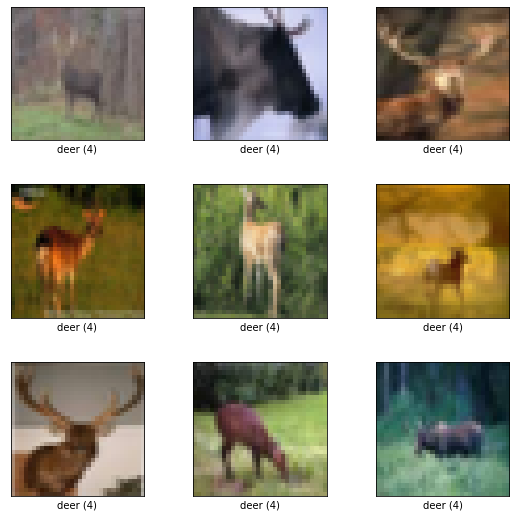

In [18]:
fig = tfds.show_examples(dataset_deers, info)

How to display one picture of a dataset using `next(iter(dataset)`

tf.Tensor(5, shape=(), dtype=int64)


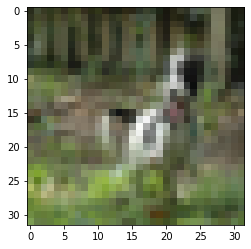

In [19]:
feature_dict = next(iter(dataset_dogs))

print(feature_dict['label'])
plt.imshow(feature_dict['image'])

# Get 1000 samples from each dataset class and create validation set

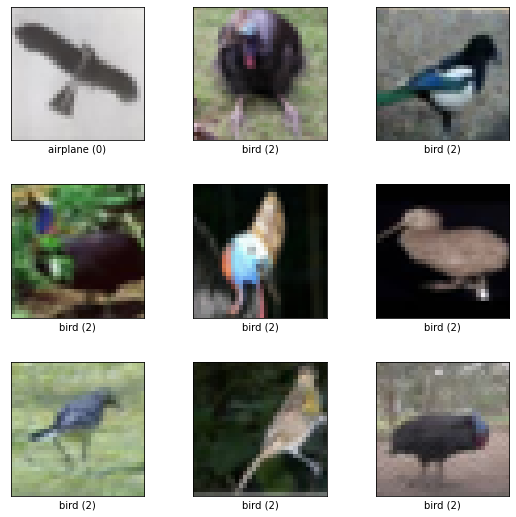

In [79]:
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobile_val  = dataset_automobile.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobile  = dataset_automobile.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# Check that remaining dataset does not have validation data
fig = tfds.show_examples(dataset_ships, info)
fig = tfds.show_examples(dataset_ships_val, info)
# I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))

# print(val.cardinality())  # -2 ?
# print(tf.data.experimental.cardinality(val).numpy()) # -2,   why?
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 1000, but it should be 10000?
# #  I tried zipping and I get a cardinality of -2 when I expected 1000*10=10,000
# print(tf.data.experimental.cardinality(dataset_airplanes_val).numpy())  # also prints -2
# print(tf.data.experimental.cardinality(dataset_airplanes).numpy()) # also prints -2
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobile_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)   # Returns a warning that the info file is not compatible

val = val.concatenate(dataset_birds_val)

#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))

# Now I need to split the remaining images of each data set into different training groups and
# I need to merge the validation sets

# mini_ds_airplanes = dataset_airplanes.skip(9)
# mini_ds_airplanes = mini_ds_airplanes.take(9)
# B = dataset_airplanes.shard(400, index=0)
# C = dataset_airplanes.shard(1000, index=1)
# list(B.as_numpy_iterator())
# list(C.as_numpy_iterator())


# mini_ds_airplanes
# plt.imshow(feature_dict['image'])
